# End-to-end multi-class dog breed classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.x and TensorFlow Hub.

## 1 Problem

Identifying the breed of a dog given an image of a dog.

When I'm sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.

## 2 Data

The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/competitions/dog-breed-identification/data

## 3 Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

## 4 Features

Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set (these images have labels).
* There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them).

## Get our workspace ready

* Import TensorFlow 2.x
* Import TensorFlow Hub
* Make sure we're using a GPU

In [1]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "available (YESSSS!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.12.0
TF Hub version: 0.13.0
GPU available (YESSSS!!!!!)


## Getting our data ready (turning into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representations).

Let's start by accessing our data and checking out the labels.

In [2]:
# Checkout the labels of our data
import pandas as pd

labels_csv = pd.read_csv("drive/MyDrive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [3]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
# How many images are there of each breed?
labels_csv["breed"].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

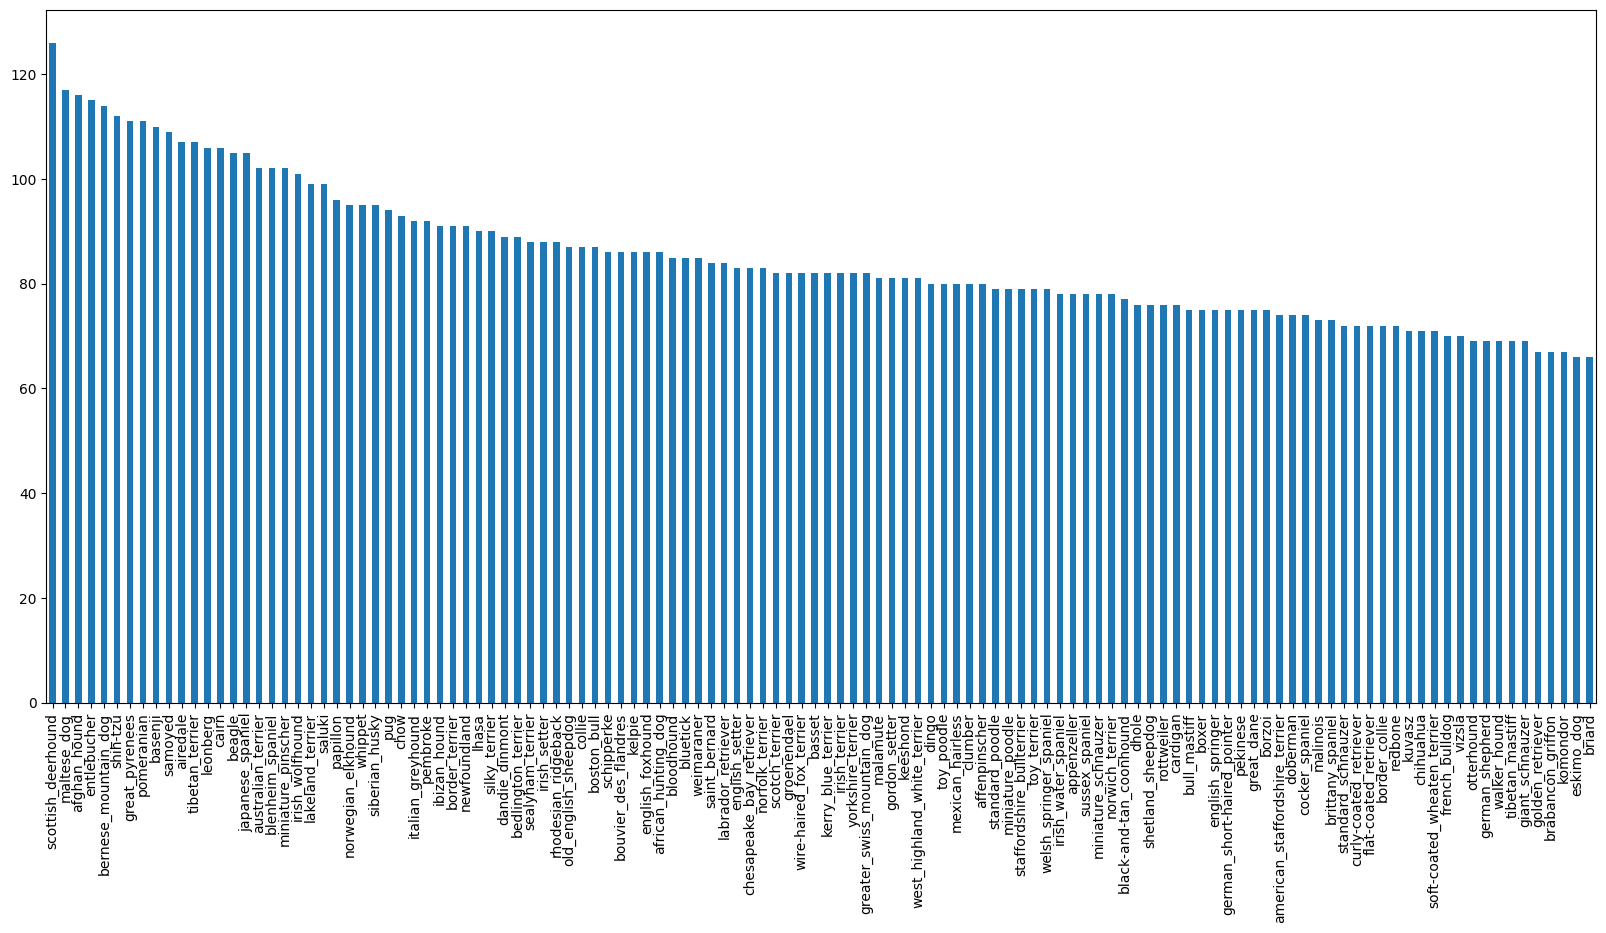

In [5]:
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 9));

In [6]:
labels_csv["breed"].value_counts().mean()

85.18333333333334

In [7]:
labels_csv["breed"].value_counts().median()

82.0

In [8]:
labels_csv.loc[1]

id       001513dfcb2ffafc82cccf4d8bbaba97
breed                               dingo
Name: 1, dtype: object

In [9]:
labels_csv["id"][1]

'001513dfcb2ffafc82cccf4d8bbaba97'

In [10]:
labels_csv["breed"][1]

'dingo'

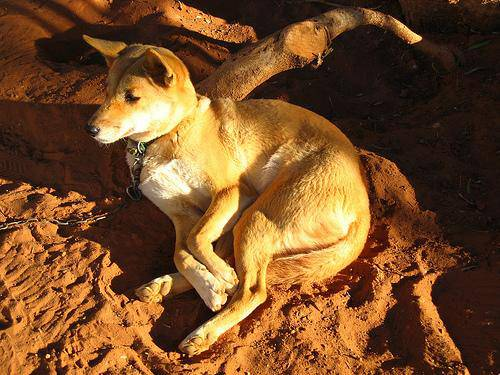

In [11]:
# Let's view an image
from IPython.display import Image

Image("drive/MyDrive/Dog Vision/train/" + labels_csv["id"][1] + ".jpg")

### Getting images and their labels

Let's get a list of all of our image file pathnames.

In [12]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [13]:
# Create filepaths from image id's (using list comprehension)
filepaths = ["drive/MyDrive/Dog Vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10
filepaths[:10]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [14]:
# Check whether number of filenames matches number of actual image files
import os

if len(os.listdir("drive/MyDrive/Dog Vision/train")) == len(filepaths):
    print("Filepaths match actual amount of files!!! Proceed.")
else:
    print("Filepaths do not match actual amount of files, check the target directory.")

Filepaths match actual amount of files!!! Proceed.


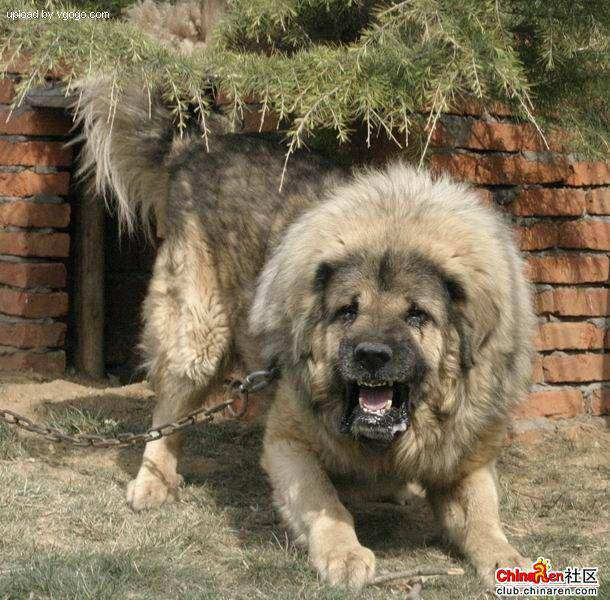

In [15]:
# One more check
Image(filepaths[9000])

In [16]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we've now got our training image filepaths in a list, let's prepare our labels.

In [17]:
labels_csv["breed"]

0                     boston_bull
1                           dingo
2                        pekinese
3                        bluetick
4                golden_retriever
                   ...           
10217                      borzoi
10218              dandie_dinmont
10219                    airedale
10220          miniature_pinscher
10221    chesapeake_bay_retriever
Name: breed, Length: 10222, dtype: object

In [18]:
import numpy as np

# labels = np.array(labels_csv["breed"])
labels = labels_csv["breed"].to_numpy()  # does the same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [19]:
len(labels)

10222

In [20]:
# See if number of labels matches the number of filepaths
if len(labels) == len(filepaths):
    print("Number of labels matches the number of filepaths!")
else:
    print("Number of labels does not match the number of filepaths, check data directories!")

Number of labels matches the number of filepaths!


In [21]:
# Find the unique values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [22]:
len(unique_breeds)

120

In [23]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [24]:
# Turn every label into a boolean array (using list comprehension)
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [25]:
len(boolean_labels)

10222

In [26]:
# Example: Turning boolean array into integers
print(labels[0])  # original label
print(np.where(labels[0] == unique_breeds))  # index where label occurs in unique breeds
print(boolean_labels[0].argmax())  # index where label occurs in boolean array
print(boolean_labels[0].astype(int))  # there will be a 1 where the sample occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [27]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [28]:
filepaths[:10]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

### Creating our own validation set

Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [29]:
# Setup X & y variables
X = filepaths
y = boolean_labels

In [30]:
len(filepaths)

10222

We're going to start off experimenting with ~1000 images and increase as needed.

In [31]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000  # @param{type: "slider", min: 1000, max: 10000, step: 1000}

In [32]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [33]:
# Let's have a geez at the training data
X_train[:5], y_train[:2]

(['drive/MyDrive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/MyDrive/Dog Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/MyDrive/Dog Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/MyDrive/Dog Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, 

### Preprocessing images (turning images into Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our `image` (convert colour channel values from 0-255 to 0-1)
4. Resize the `image` to be a shape of (224, 224)
5. Return the modified `image`

Before we do, let's see what importing an image looks like.

In [34]:
# Convert image into NumPy array
from matplotlib.pyplot import imread

image = imread(filepaths[42])
image.shape

(257, 350, 3)

In [35]:
image

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  53],
        [ 97,  88,  49],
        [120, 111,  72]]

In [36]:
image.max(), image.min()

(255, 0)

In [37]:
# Turn image into a tensor
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  5

In [38]:
image[:2]

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)

In [39]:
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

Now we've seen what an image looks like as a Tensor, let's make a function to preprocess them.

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our `image` (convert colour channel values from 0-255 to 0-1)
4. Resize the `image` to be a shape of (224, 224)
5. Return the modified `image`

In [40]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
    """
    Takes an image file path and turns the image into a Tensor.
    """
    # Read in an image file
    image = tf.io.read_file(image_path)

    # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
    image = tf.image.decode_jpeg(image, channels=3)

    # Convert the colour channel values from 0-255 to 0-1 values
    image = tf.image.convert_image_dtype(image, tf.float32)

    # Resize the image to our desired value (224, 224)
    image = tf.image.resize(image, size=[img_size, img_size])

    return image

In [41]:
tensor = tf.io.read_file(filepaths[26])
tensor

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\n\x07\x07\x08\x07\x06\n\x08\x08\x08\x0b\n\n\x0b\x0e\x18\x10\x0e\r\r\x0e\x1d\x15\x16\x11\x18#\x1f%$"\x1f"!&+7/&)4)!"0A149;>>>%.DIC<H7=>;\xff\xdb\x00C\x01\n\x0b\x0b\x0e\r\x0e\x1c\x10\x10\x1c;("(;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\xff\xc0\x00\x11\x08\x01\xf4\x01w\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca

In [42]:
tensor = tf.image.decode_jpeg(tensor, channels=3)
tensor

<tf.Tensor: shape=(500, 375, 3), dtype=uint8, numpy=
array([[[ 59,  68,  65],
        [ 64,  73,  70],
        [ 71,  80,  77],
        ...,
        [115, 128, 108],
        [115, 128, 108],
        [110, 123, 103]],

       [[ 65,  74,  71],
        [ 72,  81,  78],
        [ 79,  88,  85],
        ...,
        [114, 127, 107],
        [117, 130, 110],
        [116, 129, 109]],

       [[ 68,  77,  74],
        [ 76,  85,  82],
        [ 83,  92,  89],
        ...,
        [114, 127, 107],
        [120, 133, 113],
        [123, 136, 116]],

       ...,

       [[173, 200, 155],
        [164, 179, 136],
        [181, 166, 133],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[142, 159, 117],
        [147, 154, 113],
        [189, 174, 141],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[167, 179, 139],
        [167, 172, 132],
        [204, 188, 155],
        ...,
        [255, 255, 25

In [43]:
tensor = tf.image.convert_image_dtype(tensor, tf.float32)
tensor

<tf.Tensor: shape=(500, 375, 3), dtype=float32, numpy=
array([[[0.23137257, 0.26666668, 0.25490198],
        [0.2509804 , 0.28627452, 0.27450982],
        [0.2784314 , 0.3137255 , 0.3019608 ],
        ...,
        [0.45098042, 0.5019608 , 0.42352945],
        [0.45098042, 0.5019608 , 0.42352945],
        [0.43137258, 0.48235297, 0.4039216 ]],

       [[0.25490198, 0.2901961 , 0.2784314 ],
        [0.28235295, 0.31764707, 0.30588236],
        [0.30980393, 0.34509805, 0.33333334],
        ...,
        [0.44705886, 0.49803925, 0.41960788],
        [0.45882356, 0.50980395, 0.43137258],
        [0.454902  , 0.5058824 , 0.427451  ]],

       [[0.26666668, 0.3019608 , 0.2901961 ],
        [0.29803923, 0.33333334, 0.32156864],
        [0.3254902 , 0.36078432, 0.34901962],
        ...,
        [0.44705886, 0.49803925, 0.41960788],
        [0.47058827, 0.52156866, 0.4431373 ],
        [0.48235297, 0.53333336, 0.454902  ]],

       ...,

       [[0.6784314 , 0.7843138 , 0.60784316],
        [0.64

In [44]:
tensor = tf.image.resize(tensor, size=[IMG_SIZE, IMG_SIZE])
tensor

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.25410587, 0.2894    , 0.2776353 ],
        [0.29784313, 0.33313724, 0.32137254],
        [0.29804096, 0.33333507, 0.32157037],
        ...,
        [0.41461015, 0.46559054, 0.38715917],
        [0.44833592, 0.4993163 , 0.42088494],
        [0.44921985, 0.5002003 , 0.42176887]],

       [[0.27608263, 0.31137675, 0.29961205],
        [0.30547515, 0.34076926, 0.32900456],
        [0.2880393 , 0.3233334 , 0.3115687 ],
        ...,
        [0.41783687, 0.46881726, 0.3903859 ],
        [0.46009547, 0.51107585, 0.4326445 ],
        [0.48616162, 0.537142  , 0.45871064]],

       [[0.29875293, 0.33404705, 0.3144392 ],
        [0.27189255, 0.30718666, 0.28757882],
        [0.28608775, 0.32138187, 0.30177402],
        ...,
        [0.47503573, 0.5260161 , 0.44758475],
        [0.49345425, 0.54443467, 0.46600327],
        [0.4703167 , 0.5212971 , 0.44286573]],

       ...,

       [[0.77551085, 0.7260472 , 0.59820485],
        [0.86

In [45]:
process_image(filepaths[26])

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.25410587, 0.2894    , 0.2776353 ],
        [0.29784313, 0.33313724, 0.32137254],
        [0.29804096, 0.33333507, 0.32157037],
        ...,
        [0.41461015, 0.46559054, 0.38715917],
        [0.44833592, 0.4993163 , 0.42088494],
        [0.44921985, 0.5002003 , 0.42176887]],

       [[0.27608263, 0.31137675, 0.29961205],
        [0.30547515, 0.34076926, 0.32900456],
        [0.2880393 , 0.3233334 , 0.3115687 ],
        ...,
        [0.41783687, 0.46881726, 0.3903859 ],
        [0.46009547, 0.51107585, 0.4326445 ],
        [0.48616162, 0.537142  , 0.45871064]],

       [[0.29875293, 0.33404705, 0.3144392 ],
        [0.27189255, 0.30718666, 0.28757882],
        [0.28608775, 0.32138187, 0.30177402],
        ...,
        [0.47503573, 0.5260161 , 0.44758475],
        [0.49345425, 0.54443467, 0.46600327],
        [0.4703167 , 0.5212971 , 0.44286573]],

       ...,

       [[0.77551085, 0.7260472 , 0.59820485],
        [0.86

## Turning our data into batches

Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory.

So that's why we do about 32 (this is the batch size) images at a time (you can manually adjust the batch size if needed).

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this: `(image, label)`.

In [46]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
    """
    Takes an image file path name and the associated label, processes the image and returns a tuple of (image, label).
    """
    return process_image(image_path), label

In [47]:
# Demo of the above
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

In [48]:
get_image_label(X[42], tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of Tensors in the form: `(image, label)`, let's make a function to turn all of our data (X & y) into batches!

In [49]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    """
    Creates batches of data out of image (X) and label (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle if it's validation data.
    Also accepts test data as input (no labels).
    """
    # If the data is a test dataset, we probably don't have labels
    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices(tf.constant(X))  # only filepaths (no labels)
        data_batch = data.map(process_image).batch(batch_size)
        return data_batch
    
    # If the data is a valid dataset, we don't need to shuffle it
    elif valid_data:
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))  # filepaths, labels
        data_batch = data.map(get_image_label).batch(batch_size)
        return data_batch
    
    else:
        print("Creating training data batches...")

        # Turn filepaths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))

        # Shuffling filepaths and labels before mapping image processor function is faster than shuffling images
        data = data.shuffle(buffer_size=len(X))

        # Create (image, label) tuples (this also turns the image path into a preprocessed image)
        data = data.map(get_image_label)

        # Turn the training data into batches
        data_batch = data.batch(batch_size)
        return data_batch

In [50]:
X[:5]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [51]:
tf.constant(X[:5])

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
       b'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
       b'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
       b'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
       b'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg'],
      dtype=object)>

In [52]:
tf.data.Dataset.from_tensor_slices(tf.constant(X[:5]))

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [53]:
tf.data.Dataset.from_tensor_slices((tf.constant(X[:5]), tf.constant(y[:5])))

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(120,), dtype=tf.bool, name=None))>

In [54]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [55]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [56]:
len(train_data), len(val_data)

(25, 7)

In [57]:
800 / 32

25.0

In [58]:
200 / 32

6.25